# Monte Carlo Prediction
## 1. First-visit Monte Carlo

In [31]:
import grid_world
from grid_world import *
import numpy as np
import matplotlib.pyplot as plt

In [9]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

grid = standard_grid()

print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


In [10]:
policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
}

print("Policy:")
print_policy(policy, grid)

Policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


In [11]:
def play_game(grid, policy):
    start_states = list(grid.actions.keys())
    start_idx = np.random.choice(len(start_states))
    grid.set_state(start_states[start_idx])

    s = grid.current_state()
    states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
    while not grid.game_over():
        a = policy[s]
        r = grid.move(a)
        s = grid.current_state()
        states_and_rewards.append((s, r))
        
    G = 0
    states_and_returns = []
    first = True
    for s, r in reversed(states_and_rewards):
        if first:      #跳過第一個(最後的terminal state)
            first = False
        else:
            states_and_returns.append((s, G))
        G = r + GAMMA*G
    states_and_returns.reverse() # we want it to be in order of state visited
    return states_and_returns

In [23]:
# initialize V(s) and returns
V = {}
returns = {} # dictionary of state -> list of returns we've received
states = grid.all_states()
for s in states:
    if s in grid.actions:
        returns[s] = []
    else:
        # terminal state or state we can't otherwise get to
        V[s] = 0
        
states_and_returns = play_game(grid, policy)
print("從隨機開始點，玩一次遊戲：")
print(states_and_returns)

for t in range(100):
    states_and_returns = play_game(grid, policy)
    seen_states = set()   #創建一個無序不重複元素集
    for s, G in states_and_returns:
    # check if we have already seen s
    # called "first-visit" MC policy evaluation
        if s not in seen_states:
            returns[s].append(G)
            V[s] = np.mean(returns[s])    # Returns the average of the array elements
            seen_states.add(s)

print("\nvalues:")
print_values(V, grid)
print("\npolicy:")
print_policy(policy, grid)

從隨機開始點，玩一次遊戲：
[((0, 0), 0.81), ((0, 1), 0.9), ((0, 2), 1.0)]

values:
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-1.00| 0.00|
---------------------------
 0.66|-0.81|-0.90|-1.00|

policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


### 筆記：
蒙地卡羅預測是在沒有完整環境資訊的情況下使用。    
First-visit MC prediction 是在固定的policy之下，找到各個state的value。    
1.先選定隨機起始點，遊玩一次地圖，走到終點算是遊戲結束，此為一個episode。   
2.從終點回推各state會得到的G值，把對應state和return(G值)記錄下來。   
3.將這個episode中各state第一次出現時的return存起來。   
4.重複上述動作許多次，最後將每個state存起來的很多return值平均，就是value值。   

## 2. Monte Carlo Exploring Start

In [34]:
grid = negative_grid(step_cost=-0.9)

print("rewards:")
print_values(grid.rewards, grid)

# initialize a random policy
policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)
    
print("\nPolicy:")
print_policy(policy, grid)

rewards:
---------------------------
-0.90|-0.90|-0.90| 1.00|
---------------------------
-0.90| 0.00|-0.90|-1.00|
---------------------------
-0.90|-0.90|-0.90|-0.90|

Policy:
---------------------------
  L  |  U  |  U  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  L  |  L  |  D  |


In [35]:
def es_play_game(grid, policy):
    # returns a list of states and corresponding returns

    # reset game to start at a random position
    # we need to do this if we have a deterministic policy
    # we would never end up at certain states, but we still want to measure their value
    # this is called the "exploring starts" method
    start_states = list(grid.actions.keys())
    start_idx = np.random.choice(len(start_states))
    grid.set_state(start_states[start_idx])

    s = grid.current_state()
    a = np.random.choice(ALL_POSSIBLE_ACTIONS) # first action is uniformly random

    # be aware of the timing
    # each triple is s(t), a(t), r(t)
    # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
    states_actions_rewards = [(s, a, 0)]
    seen_states = set()
    seen_states.add(grid.current_state())
    num_steps = 0
    while True:
        r = grid.move(a)
        num_steps += 1
        s = grid.current_state()

        if s in seen_states:
            # hack so that we don't end up in an infinitely long episode
            # bumping into the wall repeatedly
            # if num_steps == 1 -> bumped into a wall and haven't moved anywhere
            #   reward = -10
            # else:
            #   reward = falls off by 1 / num_steps
            reward = -10. / num_steps
            states_actions_rewards.append((s, None, reward))
            break
        elif grid.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = policy[s]
            states_actions_rewards.append((s, a, r))
        seen_states.add(s)

    # calculate the returns by working backwards from the terminal state
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        # the value of the terminal state is 0 by definition
        # we should ignore the first state we encounter
        # and ignore the last G, which is meaningless since it doesn't correspond to any move
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + GAMMA*G
    states_actions_returns.reverse() # we want it to be in order of state visited
    return states_actions_returns

In [36]:
def max_dict(d):
    # returns the argmax (key) and max (value) from a dictionary
    # put this into a function since we are using it so often
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


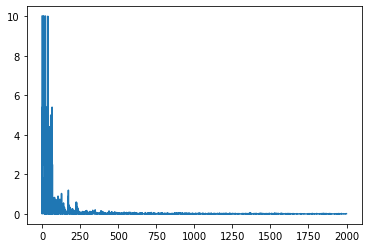

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  U  |

final values:
---------------------------
-1.91|-0.74| 1.00| 0.00|
---------------------------
-2.56| 0.00|-0.70| 0.00|
---------------------------
-3.07|-2.71|-1.66|-1.00|


In [38]:
Q = {}
returns = {}     # dictionary of state -> list of returns we've received
states = grid.all_states()

for s in states:
    if s in grid.actions: # not a terminal state
        Q[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            Q[s][a] = 0   # needs to be initialized to something so we can argmax it
            returns[(s,a)] = []
    else:                 # terminal state or state we can't otherwise get to
        pass

# repeat until convergence
deltas = []
for t in range(2000):
    if t % 100 == 0:
        print(t)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = es_play_game(grid, policy)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        sa = (s, a)
        if sa not in seen_state_action_pairs:
            old_q = Q[s][a]
            returns[sa].append(G)
            Q[s][a] = np.mean(returns[sa])
            biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
            seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # update policy
    for s in policy.keys():
        policy[s] = max_dict(Q[s])[0]

plt.plot(deltas)
plt.show()

print("final policy:")
print_policy(policy, grid)

# find V
V = {}
for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

print("\nfinal values:")
print_values(V, grid)

### 筆記：
policy是隨機決定，因此會有走向牆壁或無法行走的方塊的情況，為了避免無限迴圈，在玩遊戲時有防禦機制(再度走到同一格時，reward變很低)。
跟上一個First-visit Monte Carlo程式碼很像，不同處在於加入action影響return，且需要找到最佳policy。
要通過max_dict(d)找到每個state在該v[s]之下，最佳的前進方向(policy)。循環多次(2000次)後，就能收斂到最佳解法。

## 3. Monte Carlo with out Exploring Start(on-policy first-visit MC)
![title](image01.png)

In [48]:
def random_action(a, eps=0.1):
    # choose given a with probability 1 - eps + eps/4
    # choose some other a' != a with probability eps/4
    p = np.random.random()
    # if p < (1 - eps + eps/len(ALL_POSSIBLE_ACTIONS)):
    #   return a
    # else:
    #   tmp = list(ALL_POSSIBLE_ACTIONS)
    #   tmp.remove(a)
    #   return np.random.choice(tmp)
    #
    # this is equivalent to the above
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [39]:
def on_play_game(grid, policy):
    # returns a list of states and corresponding returns
    # in this version we will NOT use "exploring starts" method
    # instead we will explore using an epsilon-soft policy
    s = (2, 0)
    grid.set_state(s)
    a = random_action(policy[s])

    states_actions_rewards = [(s, a, 0)]
    while True:
        r = grid.move(a)
        s = grid.current_state()
        if grid.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = random_action(policy[s]) # the next state is stochastic
            states_actions_rewards.append((s, a, r))

    # calculate the returns by working backwards from the terminal state
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        # the value of the terminal state is 0 by definition
        # we should ignore the first state we encounter
        # and ignore the last G, which is meaningless since it doesn't correspond to any move
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + GAMMA*G
    states_actions_returns.reverse() # we want it to be in order of state visited
    return states_actions_returns

In [52]:
grid = negative_grid(step_cost=-0.1)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

print("\npolicy:")
print_policy(policy, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|

policy:
---------------------------
  D  |  L  |  R  |     |
---------------------------
  L  |     |  L  |     |
---------------------------
  D  |  U  |  U  |  U  |


0
1000
2000
3000
4000


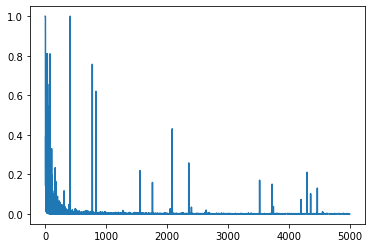


final values:
---------------------------
 0.58| 0.77| 1.00| 0.00|
---------------------------
 0.40| 0.00| 0.77| 0.00|
---------------------------
 0.25| 0.11|-0.06|-0.23|

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  L  |  L  |


In [53]:
# initialize Q(s,a) and returns
Q = {}
returns = {} # dictionary of state -> list of returns we've received
states = grid.all_states()
for s in states:
    if s in grid.actions: # not a terminal state
        Q[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            Q[s][a] = 0
            returns[(s,a)] = []
    else:
        # terminal state or state we can't otherwise get to
        pass
        
# repeat until convergence
deltas = []
for t in range(5000):
    if t % 1000 == 0:
        print(t)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = on_play_game(grid, policy)

    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
        sa = (s, a)
        if sa not in seen_state_action_pairs:
            old_q = Q[s][a]
            returns[sa].append(G)
            Q[s][a] = np.mean(returns[sa])
            biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
            seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # calculate new policy pi(s) = argmax[a]{ Q(s,a) }
    for s in policy.keys():
        a, _ = max_dict(Q[s])
        policy[s] = a

plt.plot(deltas)
plt.show()

# find the optimal state-value function
# V(s) = max[a]{ Q(s,a) }
V = {}
for s in policy.keys():
    V[s] = max_dict(Q[s])[1]

print("\nfinal values:")
print_values(V, grid)
print("\nfinal policy:")
print_policy(policy, grid)

### 筆記：
on-policy不再使用exploring start。    
先初始一個隨機的policy，他每次固定從一個起點出發(2,0)，當前進時，有一定機率會往別的方向走。     
當下一步是走向迷宮外或是不能走的格子時，他會一直在原地不動，直到觸發隨機往別的方向走，才能離開那個撞牆迴圈。    